# **SKETCH-AI**


<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/intro.png" width="60%"></center>


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#Background">Background</a>
        <ol>
            <li><a href="#What-does-a-RSU-block-consist-of?">What does a RSU block consist of?</a></li>
        </ol>
    </li>
    <li>
        <a href="#Code the RSU Blocks">Code the RSU Blocks</a>
        <ol>
            <li><a href="#RSU-7">RSU-7</a></li>
            <li><a href="#RSU-6">RSU-6</a></li>
            <li><a href="#RSU-5">RSU-5</a></li>
            <li><a href="#RSU-4">RSU-4</a></li>
            <li><a href="#RSU-4F">RSU-4F</a></li>
        </ol>
    </li>
    <li>
        <a href="#U2-Net Architecture: Two-level Nested U-structure">U2-Net Architecture: Two-level Nested U-structure</a>
        <ol>
            <li><a href="#Configure U2-Net">Configure U2-Net</a></li>
        </ol>
    </li>
    <li>
        <a href="#Use U2-Net to Draw Human Portrait">Use U2-Net to Draw Human Portrait</a>
        <ol>
            <li><a href="#Training">Training</a></li>
            <li><a href="#Pre-trained U-squared Net">Pre-trained U-squared Net</a></li>
            <li><a href="#Creating a Dataloader">Creating a Dataloader</a></li>
            <li><a href="#Inference">Inference</a></li>
            <li><a href="#Exercise: Generate your own portrait">Generate my own portrait</a></li>           
        </ol>
    </li>
</ol>


## Objectives

 - Understand the use and configuration of Residual U-blocks
 - Code Residual U-blocks with different depths in PyTorch
 - Describe the architecture of U2-Net
 - Construct U2-Net architecture using Residual U-blocks
 - Produce saliency probability maps of an input image as side outputs of U2-Net
 - Create PyTorch Dataset object and PyTorch DataLoader
 - Load the pre-trained weights of a U2-Net for inference


----


## Setup


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Importing Required Libraries


In [1]:
!pip3 install skillsnetwork

In [2]:
!pip3 install torchvision

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import skillsnetwork
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import numpy as np
from skimage import io, transform
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader



sns.set_context('notebook')
sns.set_style('white')

### Defining Helper Functions


In [4]:
def f(modules_dict, x):
    inner_enc_layers = []
    inner_dec_layers = []

    for layer_name, layer in modules_dict.items():
        if layer_name[-1] == 'd':
            inner_dec_layers.append(layer)
        else:
            inner_enc_layers.append(layer)

    hx = x
    if inner_enc_layers: 
        hxin = inner_enc_layers[0](hx)
        hx = hxin
    else:
        raise ValueError("No layers with names ending in 'd' found in modules_dict.")

    inner_enc_outputs = []

    # inner block encode
    for layer in inner_enc_layers[1:]:
        hx = layer(hx)
        if not isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
            inner_enc_outputs.append(hx)

    # inner block decode + residual function
    if inner_dec_layers:
        hxd = inner_dec_layers[0](torch.cat((inner_enc_outputs.pop(), inner_enc_outputs.pop()), 1))
        for layer in inner_dec_layers[1:]:
            hxdup = _upsample_like(hxd, inner_enc_outputs[-1])
            hxd = layer(torch.cat((hxdup, inner_enc_outputs.pop()), 1))

        return hxd + hxin
    else:
        raise ValueError("No layers with names not ending in 'd' found in modules_dict.")


In [5]:
def normPRED(d):

    """
    This function normalizes a prediction

    """

    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

The following cell defines the `RescaleT` and `ToTensor` class, which will be helpful for tensor data transformation in a later section of this project.


In [6]:
class RescaleT(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        imidx, image = sample['imidx'], sample['image']
        img = transform.resize(image, (self.output_size, self.output_size), mode='constant')

        return {'imidx':imidx, 'image':img}


class ToTensor(object):
    def __init__(self, flag=0):
        self.flag = flag

    def __call__(self, sample):
        imidx, image = sample['imidx'], sample['image']
        tmpImg = np.zeros((image.shape[0], image.shape[1], 3))
        image = image/np.max(image)

        tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
        tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
        tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225

        tmpImg = tmpImg.transpose((2,0,1))

        return {'imidx':torch.from_numpy(imidx), 'image':torch.from_numpy(tmpImg)}

## Background

Segmenting the most visually attractive objects in a given image has been one of the most well-known tasks in the field of computer vision. It has wide applications in many fields, like **visual tracking** and **image segmentation**. Here is an illustration of image segmentation:


<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/semantic_seg.png" width="65%"></center>


In the ocean of all the deep learning models, there is one name that still remains at the top, which is called U-Net. U-Net was released in 2018 and it has gained huge popularity since then for solving several different tasks related to segmentation. Below is a diagram showing the architecture of U-Net.


<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/u-net-architecture.png" width="65%"></center>


The task of detecting the most important or the **main object** in a given image is also called **Salient Object Detection** or **SOD**. With the development of deep Convolutional Neural Networks (CNNs), SOD has been significantly improved.


A common pattern in the design of most SOD networks is that they focus on using deep features extracted by existing model architectures, such as VGG, ResNet, DenseNet, etc. However, these architectures were originally designed and trained for image classification, which will not be suitable for SOD tasks that require **local details** and **global contrast information**.

We are going to talk about a variant of U-Net called **U-squared Net** or **U2-Net**. It is basically a U-Net made of U-Net or a **two-level nested U-structure**, and was designed specifically for SOD tasks.

Before we dive into the applications of U2-Net, let's first look at its key developments:

1.  It can capture more contextual information, both locally and globally, from different scales thanks to the mixture of receptive fields of different sizes in the proposed **Residual U-blocks (RSUs)**.

2.  It increases the depth of the architecture while maintaining high resolution feature maps at a low memory and computation cost, because of the dilated convolutions and pooling operations in the RSU blocks.


### What does a RSU block consist of?


- An input convolution layer, which transforms the input feature map $x$ $(H \times W \times C_{in})$ to an intermediate map $F1(x)$ with the channel of $C_{out}$. This is a plain convolutional layer for **local feature extraction**.

- A U-Net-like symmetric encoder-decoder structure with a height of $L$ that takes the intermediate feature map $F1(x)$ as input and learns to **extract and encode the multi-scale contextual information $U(F1(x))$**. Larger $L$ leads to deeper residual U-block (RSU), more pooling operations, a larger range of receptve fields, and richer local and global features. Configuring $L$ enables the extraction of multi-scale features from input feature maps with arbitrary spatial resolutions. **The multi-scale features are extracted from gradually downsampled feature maps and encoded into high resolution feature maps by progressively upsampling, concatenation and convolution.** This process mitigates the loss of fine details caused by direct upsampling with large scales.

- A residual connection that **fuses local features and multi-scale features** by the summation $ F1(x) + U(F1(x))$.


The following diagram illustrates the structure of a RSU block with $L=7$, where

- Green box represents a _Convolution+BatchNorm+ReLU_ layer;

- Blue box represents a **downsampling** _Convolution+BatchNorm+ReLU_ layer;

- Pink box represents an **upsampling** _Convolution+BatchNorm+ReLU_ layer.


<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/RSU.png" width="40%"></center>


## Code the RSU Blocks


A single RSU block consists of many _Convolution+BatchNorm+ReLU_ layers. We can create a class called `REBNCONV` that bundles the Convolution, BatchNorm, and ReLU activation layers together, so that these layers can be added to our RSU block more easily and clearly.


In [7]:
class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)


    def forward(self, x):
        hx = x
        return self.relu_s1(self.bn_s1(self.conv_s1(hx)))

Next, we define a function `_upsample_like` that upsamples `src` so that `src` has the same shape as `tar`. This will help with our concatenation of different shaped outputs later.


In [8]:
def _upsample_like(src, tar):

    src = F.upsample(src, size=tar.shape[2:], mode='bilinear')
    return src

With these two helpers, let's start creating the RSU blocks!

We will create several RSU blocks with different depths. All of them will be necessary for building our U2-Net architecture.

<p>For feature maps with large height and width, we need greater $L$ to capture more large scale information.</P>

I've simplified the forward functions of all the RSU blocks using the helper function `f`. If you are interested in knowing in detail how the layer outputs are forwarded in the RSU blocks, feel free to look at the code in the **Defining Helper Functions** section.


### RSU-7


A RSU-7 block has depth $(L)$ of 7. It consists of:

- **One** input `REBNCONV` layer;

- **Seven** downsamling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv6` and `rebnconv7` (to prevent the resolution of the last two layers being too low);

- **six** upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


In [9]:
class RSU7(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)


    def forward(self,x):

        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

### RSU-6


A RSU-6 block has depth $(L)$ of 6. It consists of:

- **One** input `REBNCONV` layer;

- **Six** downsamling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv5` and `rebnconv6` (to prevent the resolution of the last two layers being too low);

- **Five** upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


In [10]:
class RSU6(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)


    def forward(self,x):

        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result


### RSU-5


A RSU-5 block has depth $(L)$ of 5. It consists of:

- **One** input `REBNCONV` layer;

- **Five** downsamling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv4` and `rebnconv5` (to prevent the resolution of the last two layers being too low);

- **Four** upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


In [11]:
class RSU5(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)


    def forward(self,x):

        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

### RSU-4


A RSU-4 block has depth $(L)$ of 4. It consists of:

- **One** input `REBNCONV` layer;

- **Four** downsamling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv3` and `rebnconv4` (to prevent the resolution of the last two layers being too low);

- **Three** upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


In [12]:
class RSU4(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        # your code here
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)


    def forward(self,x):

        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result


### RSU-4F


The RSU-4F block is slightly different from other RSU-L blocks. **"F"** means that the RSU is a dilated version, where we replace the pooling the upsampling operations with dilated convolutions. This means all of intermediate feature maps of RSU-4F have the same resolution with its input feature maps.

A RSU-4F has depth $(L)$ of 4. It consists of:

- **One** input `REBNCONV` layer;

- **Four** dilated `REBNCONV` layers, each produces output of the same shape as the input.

- **Three** dilated `REBNCONV` layers, each takes the concatenation of the feature maps from its previous layer and those from its symmetrical layer as input.


In [13]:
class RSU4F(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)


    def forward(self,x):

        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

We have finished creating all the RSU blocks that are required for the complete U2-Net architecture!

We can print out the `named_parameters` of a RSU block to see the parameters associated with each of the layers we included in the block.


In [14]:
for name, param in RSU4F().named_parameters():
    print(name)

rebnconvin.conv_s1.weight
rebnconvin.conv_s1.bias
rebnconvin.bn_s1.weight
rebnconvin.bn_s1.bias
rebnconv1.conv_s1.weight
rebnconv1.conv_s1.bias
rebnconv1.bn_s1.weight
rebnconv1.bn_s1.bias
rebnconv2.conv_s1.weight
rebnconv2.conv_s1.bias
rebnconv2.bn_s1.weight
rebnconv2.bn_s1.bias
rebnconv3.conv_s1.weight
rebnconv3.conv_s1.bias
rebnconv3.bn_s1.weight
rebnconv3.bn_s1.bias
rebnconv4.conv_s1.weight
rebnconv4.conv_s1.bias
rebnconv4.bn_s1.weight
rebnconv4.bn_s1.bias
rebnconv3d.conv_s1.weight
rebnconv3d.conv_s1.bias
rebnconv3d.bn_s1.weight
rebnconv3d.bn_s1.bias
rebnconv2d.conv_s1.weight
rebnconv2d.conv_s1.bias
rebnconv2d.bn_s1.weight
rebnconv2d.bn_s1.bias
rebnconv1d.conv_s1.weight
rebnconv1d.conv_s1.bias
rebnconv1d.bn_s1.weight
rebnconv1d.bn_s1.bias


We can see that the parameters are associated with the Convolution and the BatchNorm layer of `REBNCONV`.


## U2-Net Architecture: Two-level Nested U-structure


The U2-Net is a **two-level nested U-structure**. As shown in the figure below, its top level is a big U-structure consists of 11 stages where each stage is a RSU block (bottom level U-structure). Thus, the nested U-structure enables the **extraction of intra-stage multi-scale features** and **aggregation of inner-stage multi-level features**.


<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/U2Net.png" width="70%"></center>


### Configure U2-Net


Using all the RSU-L blocks and the RSU-4F block we created previously, let's configure the U2-Net. In a nutshell, the U2-Net mainly consists of three parts:

- **a six stages encoder** composed of RSU-7, RSU-6, RSU-5, RSU-4, RSU-4F, and RSU-4F;

- **a five stages decoder** composed of RSU-4F, RSU-4, RSU-5, RSU-6, and RSU-7;  

- **a saliency map fusion module** attached with the decoder stages and the last encoder stage for generating side output saliency probability maps; they will be fused to produce the final saliency probability map.

<p>Each decoder stage takes the concatenation of the decoded feature maps from its previous stage and those from its symmetrical encoder stage as the input.</p>


In [15]:
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        # encoder
        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        #side
        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)


    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0) #, F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)


The forward function of U2-Net returns the final saliency probability map $sigmoid(d_0)$ that's generated using the side outputs $d_1,d_2, d_3, d_4, d_5, d_6$. Depending on the application of U2-Net, the final saliency probability map can be used differently to produce the final product desired.


## Use U2-Net to Draw Human Portrait


One of the interesting applications of U2-Net is human portrait generation. In this section, we will import the pre-trained weights of the U2-Net and load them into our model architecture.



### Pre-trained U-squared Net


We create a U2-Net model using our defined class `U2NET`and call it `net`.


In [16]:
net = U2NET(3, 1)

Downloading the model weights and load them into `net`:


In [17]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/LargeData/u2net.tgz", "pretrained_u2net", overwrite=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Saved to 'pretrained_u2net'


In [18]:
net.load_state_dict(torch.load("pretrained_u2net/u2net.pth", map_location='cpu'), strict=False)

<All keys matched successfully>

To use the U2-Net for human portrait generation, let's first prepare some test photos of human faces.


In [19]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/data/test.tgz", overwrite=True)

  0%|          | 0/23 [00:00<?, ?it/s]

Saved to '.'


### Creating a Dataloader


We need to create a PyTorch dataloader for feeding the test data to `net`. The `LoadDataset` class can produce a PyTorch Dataset object that generates samples of test images.


In [20]:
class LoadDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_name_list = [x for x in os.listdir(img_dir) if not x.startswith(".")]


    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.img_name_list[idx])
        image = io.imread(img_name)
        imidx = np.array([idx])
        sample = {'imidx':imidx, 'image':image}

        if self.transform:
            sample = self.transform(sample)

        return sample


As the test photos were downloaded to the `images` folder, we pass the path to `LoadDataset`. We also specify that we want to transform the images using `RescaleT` and `ToTensor`, which were defined previously in the **Defining Helper Functions** section.


In [21]:
photos_dataset = LoadDataset(img_dir = 'images/test_photos',
                             transform = transforms.Compose([RescaleT(512),
                                                             ToTensor(0)]))

We create a PyTorch dataloader called `photos_dataloader` with `photos_dataset`. Batch size equals 1 because we will inference one photo at a time.


In [22]:
photos_dataloader = DataLoader(photos_dataset,
                               batch_size=1)

Let's visualize the photos in our `photos_dataloader`:


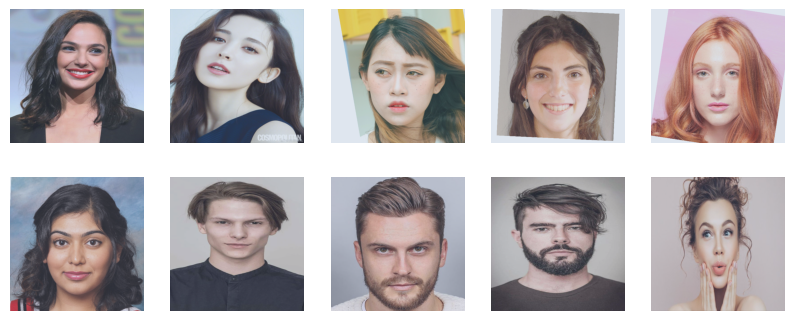

In [23]:
fig = plt.figure(figsize=(10,4))

for i, sample in enumerate(photos_dataloader):
    img_arr = np.transpose((sample['image'].numpy()[0]+3)/6, (1,2,0))
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(img_arr)
    ax.axis("off")

We have photos of 10 human faces, which we will now pass to our U2-Net `net` for generating portraits of these faces.


### Inference!


The code below takes care of the inference procedure. For each input image, it takes the saliency probability map predicted by the U2-Net, normalizes the prediction, and converts it back to a RGB image for visualization. It should take less than 5 minutes to finish inferencing 10 images.


In [ ]:
fig = plt.figure(figsize=(10,4))

for i, sample in enumerate(photos_dataloader):


    print(f"inferencing photo #{i+1}:")

    input_test = sample['image']
    input_test = input_test.type(torch.FloatTensor)
    input_test = Variable(input_test)

    d = net(input_test)

    # normalization
    pred = 1.0 - d[:,0,:,:]
    pred = normPRED(pred)

    predict = pred.squeeze()
    predict_np = predict.cpu().data.numpy()
    img = Image.fromarray(predict_np*255).convert('RGB')
    img_array = np.array(img)

    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(img_array)
    ax.axis("off")

    del input_test, d, pred, predict, predict_np, img, img_array

### Generate your own portrait


In [ ]:
your_dataset = LoadDataset(img_dir = 'test',
                             transform = transforms.Compose([RescaleT(512),
                                                             ToTensor(0)]))
your_dataloader = DataLoader(your_dataset,
                               batch_size=1)

inferencing photo #1:
inferencing photo #2:
inferencing photo #3:


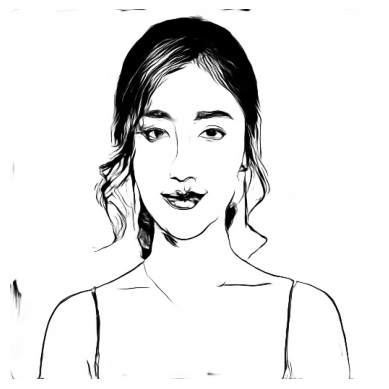

In [ ]:
for i, sample in enumerate(your_dataloader):


    print(f"inferencing photo #{i+1}:")

    input_test = Variable(sample['image'].type(torch.FloatTensor))
    d = net(input_test)

    # normalization
    pred = normPRED(1.0 - d[:,0,:,:])

    predict = pred.squeeze().cpu().data.numpy()
    img = Image.fromarray(predict*255).convert('RGB')

    plt.imshow(np.array(img))
    plt.axis("off")

    del input_test, d, pred, predict, img